In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math

# Reading Data from Files

In [2]:
fileprefix = "pilot_2" # pilot_[1,2]
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [3]:
# Testing getting expected score of one trial

with open(all_part_paths[1], 'r') as f:
    participant = json.load(f)

for idx, trial in enumerate(participant['data']):
    trial_type = trial['trialdata']['trial_type']
    try:
        trial_id = str(trial['trialdata']['trial_id'])
    except KeyError:
        trial_id = ""
        
    if trial_type == "mouselab-mdp" and not trial_id.startswith("practice"):
        selected_trial = trial
        break

g_truth = [0.0] + selected_trial['trialdata']['stateRewards'][1:]
mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
clicks = selected_trial['trialdata']['queries']['click']['state']['target']
clicks = [int(click) for click in clicks]
for click in clicks:
    mEnv.step(clicks[0])
mEnv._state
# mEnv._term_reward()

(0, -2.0, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat)

# Creating Trial Dataframe

In [4]:
part_stats_dicts = []
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    rewardsWithheld = []
    effort = "-1"
    
    firstTrialStamp = participant['data'][0]['dateTime']
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
#         if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
#             print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                expectedScores.append(mEnv._term_reward() + trial['trialdata']['costs'])
                
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
            
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

In [5]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": [],
    "rewardsWithheld" : []
}

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        print(part['condition'], part['workerId'])
        continue
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['rewardsWithheld'] += part['rewardsWithheld']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


1 5fa7e834819bc858e470ae14
1 60f35298d49211f5e58f2ac2
1 5df76aff2d2185502504d15c
1 5e82336768080c958df984c1
1 5f71e885e4c6b907c3c3610f
1 5c5dfb15034e2800016454aa
1 613cfaecee50fc5d702c9cfc
1 5f8d00ca25aa354b7063d7c7
2 614f45a5dbb73599b9fdc65b
1 60c49e68081928c86ba7b98a
2 614a360a9ff931cef70c2a33
1 5f503987fc18901a2c94c407
1 5e8a0912524dca6ad71ecb86
2 6113dc7ee718f73116fcdc8a
1 5acdd627436f5500010046ac
1 60a51393b86b6c9753bb36da
1 5e0f649eabec5d678a6f11bb
1 5efa1c514003e68155b99a93
1 616aea6b17045149d16aca39
0 61670b85f91be7f7618712b5
2 5f58d87950e39f07ad1ba367
1 5c3747496d465f00011a4d21
1 6151c64a4c0d073be1927c49
1 62cea839eb104e720d1fc9b3
1 60f5a773c448898bf72987bc
1 61212548227146794559af84
2 60e46e6f6bc0c2cdf5d077ce


In [6]:
all_trials_df

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,38.0,9.0,1,0,0,0,6140be2fdc5e6f433f412f7a,False
1,30.0,1.0,2,0,1,0,6140be2fdc5e6f433f412f7a,False
2,30.0,25.0,3,0,2,0,6140be2fdc5e6f433f412f7a,False
3,25.0,20.0,4,0,3,0,6140be2fdc5e6f433f412f7a,False
4,52.0,-1.0,5,0,4,0,6140be2fdc5e6f433f412f7a,False
...,...,...,...,...,...,...,...,...
2935,40.0,35.0,26,0,25,0,6130ceb2390f7cb3284f33a9,False
2936,31.0,26.0,27,0,26,0,6130ceb2390f7cb3284f33a9,False
2937,26.0,21.0,28,0,27,0,6130ceb2390f7cb3284f33a9,False
2938,58.0,53.0,29,0,28,0,6130ceb2390f7cb3284f33a9,False


## Removing Outliers

In [7]:
# Removing outliers 

# Excluding participants who have average final/expected scores further than 2.5 deviations from mean


average_scores = all_trials_df.groupby("workerId").mean()
excluded_parts = average_scores[np.abs(scipy.stats.zscore(average_scores.expectedScores)) > 2.5]
included_parts = average_scores[np.abs(scipy.stats.zscore(average_scores.expectedScores)) <= 2.5]
print("Number of participants excluded: {0} ({1:0.2f}%)".format(len(excluded_parts), 100*len(excluded_parts)/(len(excluded_parts) + len(included_parts))))
included_part_IDs = list(included_parts.index)
outliers_excluded_part = all_trials_df.loc[all_trials_df.workerId.isin(included_part_IDs)].reset_index(drop=True)
outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')

# Excluding the trials of participants that had a significantly low score

outliers_excluded_trial = pd.DataFrame(columns=outliers_excluded_part.columns)
for trial in np.unique(outliers_excluded_part.trialNumbers):
    trialRowsScarce = outliers_excluded_part.loc[(outliers_excluded_part.trialNumbers == trial) & (outliers_excluded_part.scarce == 1)].reset_index(drop=True)
    included = trialRowsScarce[(np.abs(scipy.stats.zscore(trialRowsScarce.expectedScores)) < 3)]
    outliers_excluded_trial = pd.concat([outliers_excluded_trial,included], ignore_index=True)
    
    if trial <= 30:
        trialRowsControl = outliers_excluded_part.loc[(outliers_excluded_part.trialNumbers == trial) & (outliers_excluded_part.scarce == 0)].reset_index(drop=True)
        included = trialRowsControl[(np.abs(scipy.stats.zscore(trialRowsControl.expectedScores)) < 3)]
        outliers_excluded_trial = pd.concat([outliers_excluded_trial,included], ignore_index=True)

outliers_excluded_trial['trialNumbers'] = outliers_excluded_trial['trialNumbers'].astype('int64')
outliers_excluded_trial['scarce'] = outliers_excluded_trial['scarce'].astype('int64')
outliers_excluded_trial['numRewardedTrials'] = outliers_excluded_trial['numRewardedTrials'].astype('int64')
outliers_excluded_trial['numUnrewardedTrials'] = outliers_excluded_trial['numUnrewardedTrials'].astype('int64')

print("Number of trials excluded after participant exclusion: {0} ({1:0.2f}%)".format(len(outliers_excluded_part)-len(outliers_excluded_trial), 100-100*len(outliers_excluded_trial)/(len(outliers_excluded_part))))
print("Number of total trials excluded: {0} ({1:0.2f}%)".format(len(all_trials_df)-len(outliers_excluded_trial), 100-100*len(outliers_excluded_trial)/(len(all_trials_df))))


Number of participants excluded: 3 (7.32%)
Number of trials excluded after participant exclusion: 13 (0.46%)
Number of total trials excluded: 103 (3.50%)


In [8]:
outliers_excluded_trial

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,63.75,58.75,1,1,0,0,612288702a5316519e4e9602,True
1,38.50,1.50,1,1,0,0,5f5a69a0b2b7c2119ecf07bf,False
2,60.75,-0.25,1,1,0,0,614775c6f329a9e5ab190e04,False
3,-7.75,3.25,1,1,0,0,60b240b5ea9091ab2f12568b,True
4,27.25,22.25,1,1,0,0,60d4c52faeecc354694c9fe7,True
...,...,...,...,...,...,...,...,...
2832,57.75,50.75,120,1,30,89,5f63c23441886d11737a8c4f,True
2833,47.00,42.00,120,1,30,89,615325dde7a4d7a78fa314b5,True
2834,42.50,47.50,120,1,30,89,612f3f73f0f8086722abf5c5,True
2835,46.75,47.75,120,1,30,89,60abf71aa3abebc8ba3c5b67,True


In [9]:
# Data to use for the remainder of the analysis

filtered_data = outliers_excluded_part

# Visualizing Data

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_7818/3024295423.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


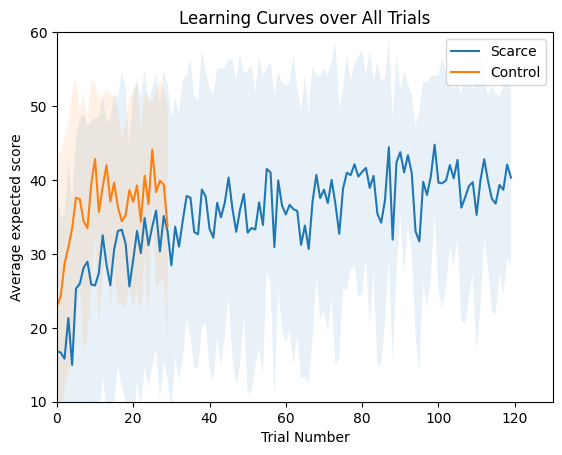

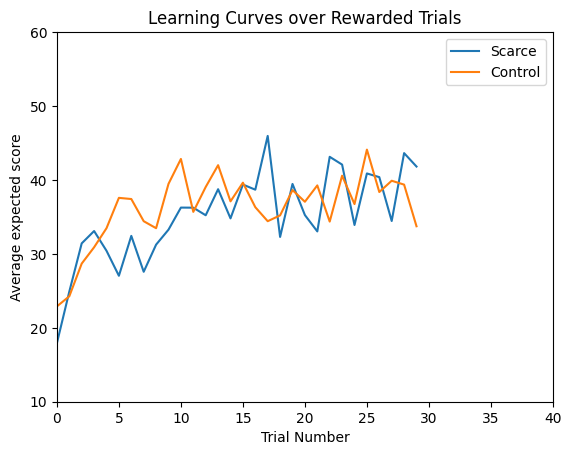

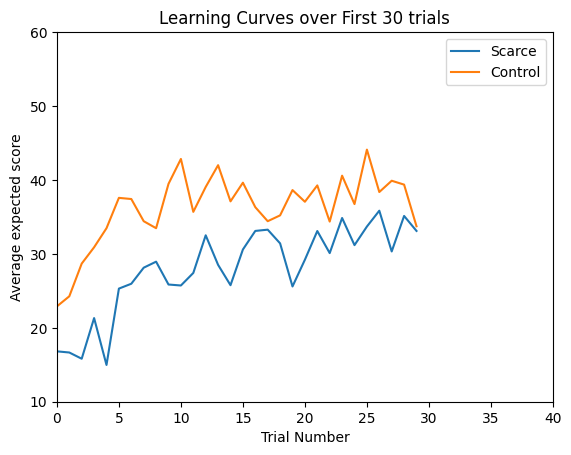

In [10]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_data_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["expectedScores"])
scarce_data_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["expectedScores"])
control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["expectedScores"])
control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["expectedScores"])
scarce_data_first_30 = scarce_data_all[0:30]
scarce_data_first_30_sd = scarce_data_all_sd[0:30]

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["expectedScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["expectedScores"])

plt.figure()
plt.title("Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over First 30 trials")
plt.plot(list(range(len(scarce_data_first_30))), scarce_data_first_30, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()



# 0.1 - Transforming Response Data

In [11]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

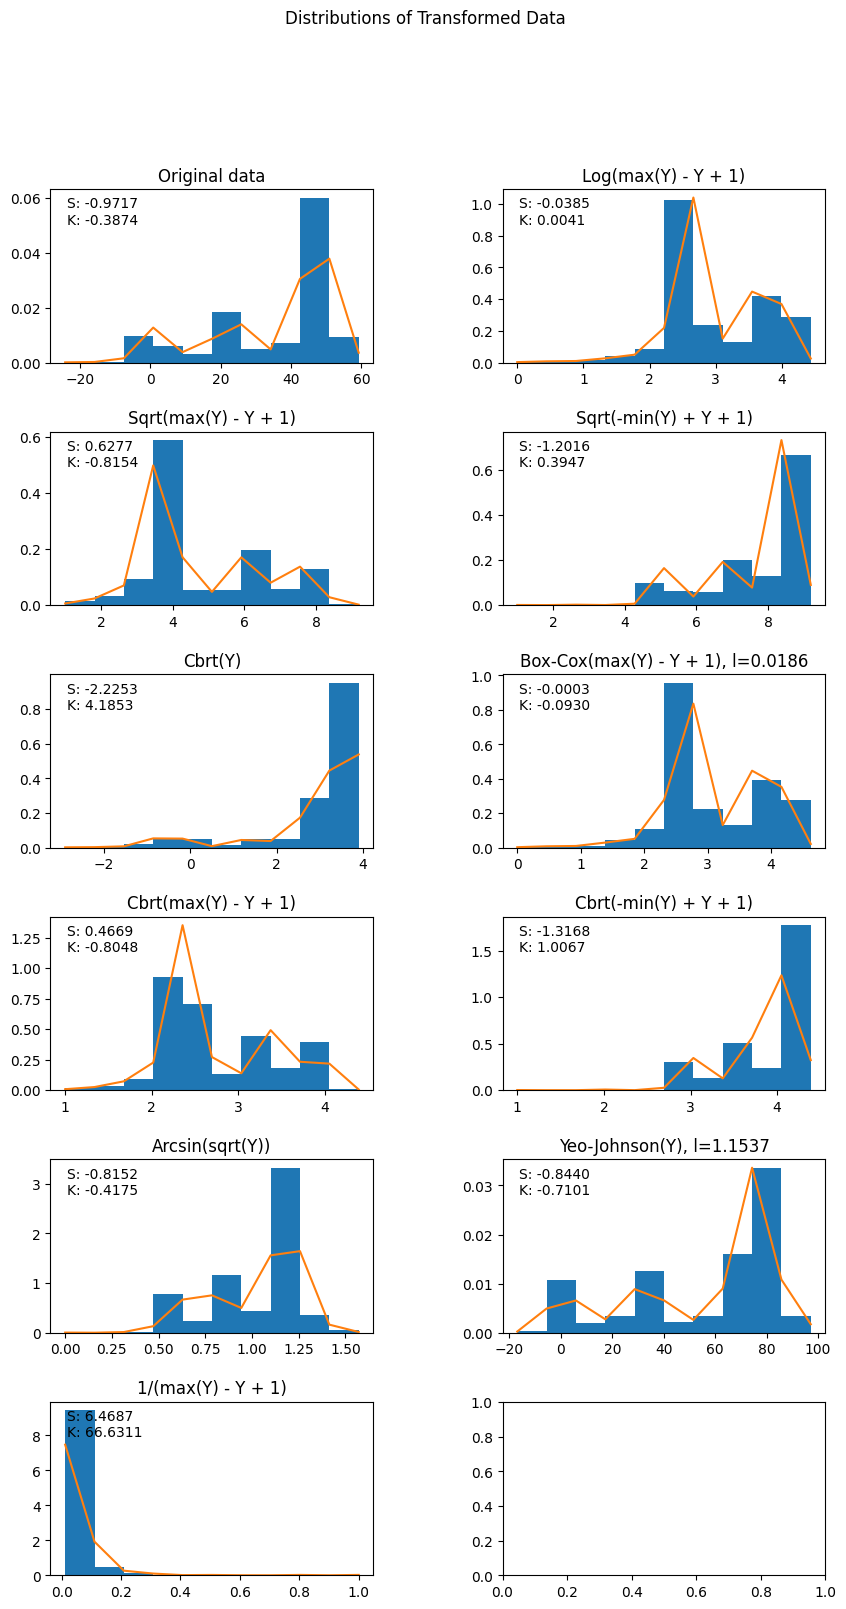

In [12]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded

transformed_trials_df = data_to_copy.copy()
log_transformed_trials_df = data_to_copy.copy()
sq_transformed_trials_df = data_to_copy.copy()
sq2_transformed_trials_df = data_to_copy.copy()
cb_transformed_trials_df = data_to_copy.copy()
cb2_transformed_trials_df = data_to_copy.copy()
cb3_transformed_trials_df = data_to_copy.copy()
arcsin_transformed_trials_df = data_to_copy.copy()
bc_transformed_trials_df = data_to_copy.copy()
yj_transformed_trials_df = data_to_copy.copy()
inverse_transformed_trials_df = data_to_copy.copy()


log_transformed_trials_df['expectedScores'] = np.log(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq_transformed_trials_df['expectedScores'] = np.sqrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq2_transformed_trials_df['expectedScores'] = np.sqrt(-transformed_trials_df['expectedScores'].min() + 1 + transformed_trials_df['expectedScores'])
cb_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'])
cb2_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
cb3_transformed_trials_df['expectedScores'] = np.cbrt(-transformed_trials_df['expectedScores'].min() + 1 + transformed_trials_df['expectedScores'])
arcsin_transformed_trials_df['expectedScores'] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df['expectedScores'], 0, 1)))
bc_transformed_trials_df['expectedScores'],lam = scipy.stats.boxcox(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
#logit_transformed_trials_df['expectedScores'] = scipy.special.logit(scale_to_range(transformed_trials_df['expectedScores'], 0, 1))
yj_transformed_trials_df['expectedScores'],lam_y = scipy.stats.yeojohnson(transformed_trials_df['expectedScores'])
inverse_transformed_trials_df['expectedScores'] = 1/(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])

trans_list = [
    (transformed_trials_df, "Original data"),
    (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
    (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
    (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
    (cb_transformed_trials_df, "Cbrt(Y)"),
    (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
    (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
    (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
    (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
    (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
    (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
]

fig, ax = plt.subplots(nrows=math.ceil(len(trans_list)/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list)/2)),squeeze=False)
plt.suptitle("Distributions of Transformed Data")
ax = ax.flatten()

for idx, trans in enumerate(trans_list):
    data = trans[0]['expectedScores']
    label = trans[1]
    skew = scipy.stats.skew(data)
    density = scipy.stats.gaussian_kde(data)
    kurtosis = scipy.stats.kurtosis(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

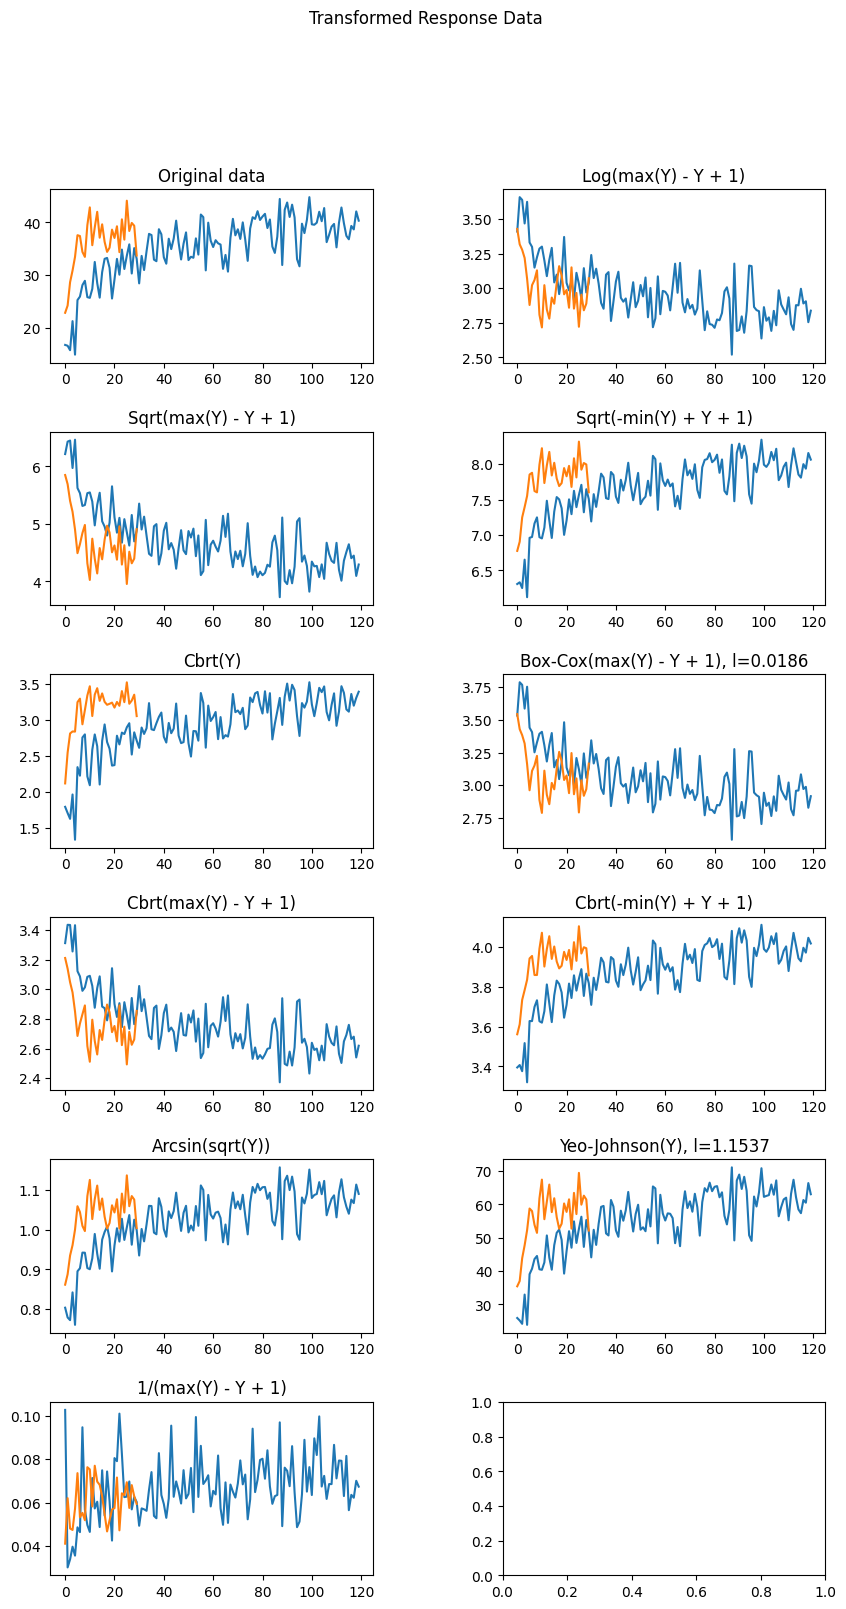

In [13]:
# Plotting the response data

fig, ax = plt.subplots(nrows=math.ceil(len(trans_list)/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list)/2)),squeeze=False)
plt.suptitle("Transformed Response Data")
ax = ax.flatten()

for idx, trans in enumerate(trans_list):
    data = trans[0]
    scarce = data.loc[data.scarce == 1]
    control = data.loc[data.scarce == 0]
    label = trans[1]
    
    scarce_mean = np.array(scarce.groupby('trialNumbers').mean()['expectedScores'])
    control_mean = np.array(control.groupby('trialNumbers').mean()['expectedScores'])
    ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
    ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
    ax[idx].set_title(label)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [14]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
formula = "expectedScores ~ C(trialNumbers) + C(scarce)"

In [15]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = []

mixed = True

for idx, trans in enumerate(trans_list):
    if mixed:
        glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
    else:
        glm = smf.glm(formula=formula, data=trans[0])

    results = glm.fit()

    print("\n{}:".format(trans[1]))
    print(results.summary())
    
    resids = results.resid_response if not mixed else results.resid
    normaltest = scipy.stats.normaltest(resids)
    all_residuals.append((
        resids,
        trans[1],
        normaltest
    ))



Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   2850      Method:               REML          
No. Groups:         38        Scale:                206.4403      
Min. group size:    30        Log-Likelihood:       -11387.2571   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.0                                          
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              23.967    2.949  8.127 0.000  18.187 29.747
C(trialNumbers)[T.2]    0.605    3.296  0.184 0.854  -5.855  7.066
C(trialNumbers)[T.3]    2.395    3.296  0.727 0.468  -4.066  8.855
C(trialNumbers)[T.4]    6.250    3.296  1.896 0.058  -0.211 12.711
C(trialNumbers)[T.5]    4.368    3.296  1.325 0.185  -2.092 1


Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.3736        
Min. group size:     30       Log-Likelihood:      -2764.6797    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.318    0.118 28.064 0.000  3.086  3.550
C(trialNumbers)[T.2]    0.069    0.140  0.490 0.624 -0.206  0.343
C(trialNumbers)[T.3]    0.039    0.140  0.278 0.781 -0.236  0.314
C(trialNumbers)[T.4]   -0.076    0.140 -0.540 0.589 -0.351  0.199
C(trialNumbers)[T.5]   -0.073    0.140 -0.518 0.604 -0.348  0.202
C(


Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               1.9532        
Min. group size:     30       Log-Likelihood:      -5025.4926    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               5.706    0.280 20.391 0.000  5.157  6.254
C(trialNumbers)[T.2]    0.029    0.321  0.090 0.928 -0.600  0.657
C(trialNumbers)[T.3]   -0.107    0.321 -0.334 0.738 -0.736  0.521
C(trialNumbers)[T.4]   -0.441    0.321 -1.374 0.169 -1.069  0.188
C(trialNumbers)[T.5]   -0.349    0.321 -1.089 0.276 -0.977  0.279
C


Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               1.0470        
Min. group size:     30       Log-Likelihood:      -4177.8962    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.859    0.212 32.388 0.000  6.444  7.275
C(trialNumbers)[T.2]    0.077    0.235  0.328 0.743 -0.383  0.537
C(trialNumbers)[T.3]    0.208    0.235  0.885 0.376 -0.252  0.668
C(trialNumbers)[T.4]    0.482    0.235  2.051 0.040  0.021  0.942
C(trialNumbers)[T.5]    0.295    0.235  1.256 0.209 -0.165  0.755



Cbrt(Y):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.9682        
Min. group size:     30       Log-Likelihood:      -4071.9917    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.307    0.205 11.226 0.000  1.904  2.709
C(trialNumbers)[T.2]    0.171    0.226  0.757 0.449 -0.272  0.613
C(trialNumbers)[T.3]    0.264    0.226  1.168 0.243 -0.179  0.706
C(trialNumbers)[T.4]    0.447    0.226  1.982 0.047  0.005  0.890
C(trialNumbers)[T.5]    0.131    0.226  0.582 0.561 -0.311  0.574
C(trialNumbers


Box-Cox(max(Y) - Y + 1), l=0.0186:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.4159        
Min. group size:     30       Log-Likelihood:      -2911.2242    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.431    0.125 27.460 0.000  3.186  3.676
C(trialNumbers)[T.2]    0.070    0.148  0.471 0.638 -0.220  0.360
C(trialNumbers)[T.3]    0.037    0.148  0.249 0.803 -0.253  0.327
C(trialNumbers)[T.4]   -0.086    0.148 -0.578 0.563 -0.376  0.204
C(trialNumbers)[T.5]   -0.081    0.148 -0.548 0.584 -0


Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.3052        
Min. group size:     30       Log-Likelihood:      -2491.7537    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.144    0.109 28.711 0.000  2.929  3.358
C(trialNumbers)[T.2]    0.026    0.127  0.204 0.838 -0.223  0.274
C(trialNumbers)[T.3]   -0.020    0.127 -0.162 0.872 -0.269  0.228
C(trialNumbers)[T.4]   -0.144    0.127 -1.139 0.255 -0.393  0.104
C(trialNumbers)[T.5]   -0.120    0.127 -0.945 0.344 -0.368  0.129
C


Cbrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.1297        
Min. group size:     30       Log-Likelihood:      -1327.9565    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.591    0.075 48.156 0.000  3.445  3.737
C(trialNumbers)[T.2]    0.031    0.083  0.377 0.706 -0.131  0.193
C(trialNumbers)[T.3]    0.077    0.083  0.933 0.351 -0.085  0.239
C(trialNumbers)[T.4]    0.172    0.083  2.087 0.037  0.011  0.334
C(trialNumbers)[T.5]    0.100    0.083  1.208 0.227 -0.062  0.262



Arcsin(sqrt(Y)):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.0385        
Min. group size:     30       Log-Likelihood:      330.1910      
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.883    0.040 22.213 0.000  0.805  0.961
C(trialNumbers)[T.2]    0.001    0.045  0.018 0.986 -0.087  0.089
C(trialNumbers)[T.3]    0.021    0.045  0.468 0.640 -0.067  0.109
C(trialNumbers)[T.4]    0.069    0.045  1.535 0.125 -0.019  0.157
C(trialNumbers)[T.5]    0.048    0.045  1.059 0.289 -0.041  0.136
C(tria


Yeo-Johnson(Y), l=1.1537:
               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   expectedScores
No. Observations:    2850      Method:               REML          
No. Groups:          38        Scale:                555.2992      
Min. group size:     30        Log-Likelihood:       -12736.6692   
Max. group size:     120       Converged:            Yes           
Mean group size:     75.0                                          
-------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept               37.034    4.799  7.718 0.000  27.629 46.440
C(trialNumbers)[T.2]     0.425    5.406  0.079 0.937 -10.171 11.021
C(trialNumbers)[T.3]     3.332    5.406  0.616 0.538  -7.264 13.927
C(trialNumbers)[T.4]     9.664    5.406  1.788 0.074  -0.932 20.260
C(trialNumbers)[T.5]     7.390    5.


1/(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    2850     Method:              REML          
No. Groups:          38       Scale:               0.0037        
Min. group size:     30       Log-Likelihood:      3557.5017     
Max. group size:     120      Converged:           Yes           
Mean group size:     75.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.071    0.011  6.699 0.000  0.050  0.092
C(trialNumbers)[T.2]   -0.026    0.014 -1.851 0.064 -0.053  0.002
C(trialNumbers)[T.3]   -0.031    0.014 -2.219 0.026 -0.058 -0.004
C(trialNumbers)[T.4]   -0.028    0.014 -2.034 0.042 -0.056 -0.001
C(trialNumbers)[T.5]   -0.025    0.014 -1.832 0.067 -0.053  0.002
C(t

/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


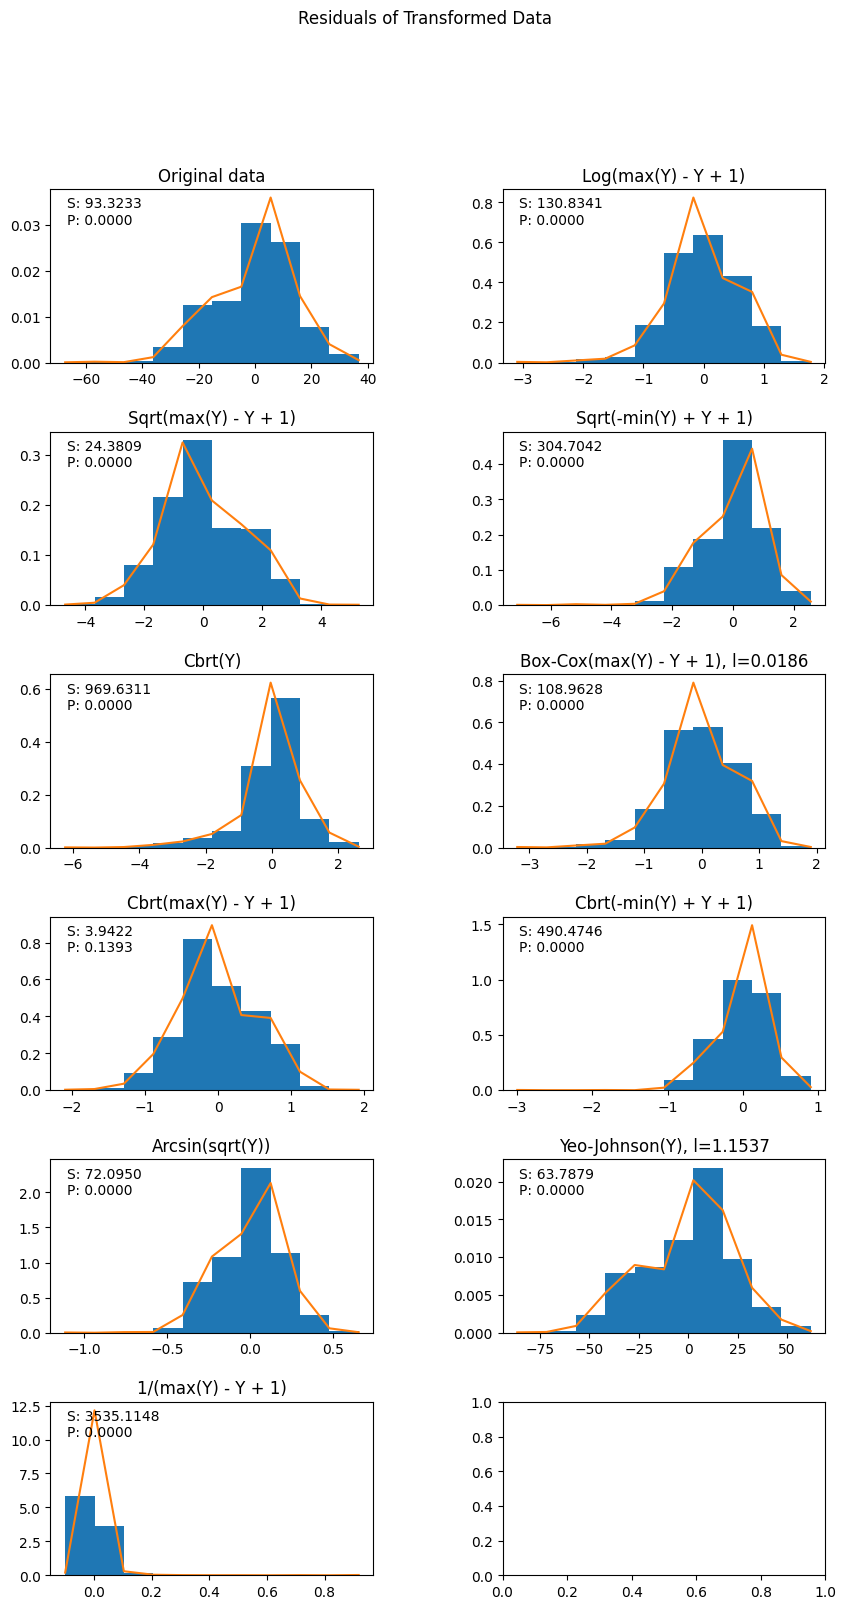

In [16]:
# Plotting residuals for all GLM Models

fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals)/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals)/2)),squeeze=False)
plt.suptitle("Residuals of Transformed Data")
ax = ax.flatten()

for idx, trans in enumerate(all_residuals):
    data = trans[0]
    label = trans[1]
    normaltest = trans[2]
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [17]:
# data which is to be used for the remainder of the analysis

analysis_data = cb2_transformed_trials_df

In [18]:
# Scarce

scarce = analysis_data.loc[analysis_data.scarce == 1]

scarce.corr()

control = analysis_data.loc[analysis_data.scarce == 0]

control.corr()

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,rewardsWithheld
trialScores,1.000000,-0.769630,0.143307,NaN,0.143307,NaN,NaN
expectedScores,-0.769630,1.000000,-0.155096,NaN,-0.155096,NaN,NaN
trialNumbers,0.143307,-0.155096,1.000000,NaN,1.000000,NaN,NaN
scarce,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numRewardedTrials,0.143307,-0.155096,1.000000,NaN,1.000000,NaN,NaN
numUnrewardedTrials,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rewardsWithheld,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1.1.0 - Linear Regression: Finding Cut-off Point for Learning Phase

### Finding Cut-off Point for Scarce Condition

In [429]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1]

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_z_scores_scarce = []
scarce_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_scarce.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_scarce[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[8.]


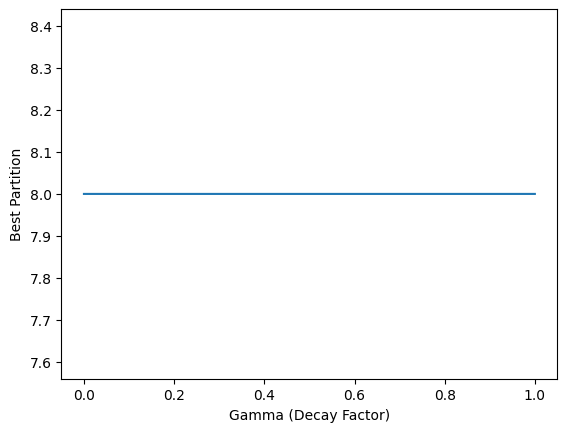

In [430]:
# Finding the best partition of all significant ones 

sig_z_scores_scarce = np.array(sig_z_scores_scarce)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_scarce[:,2] * (gamma ** sig_z_scores_scarce[:,0])
    
    # Sum of absolute correlation coeffs
    partition_scores = sig_z_scores_scarce[:,4] + sig_z_scores_scarce[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_scarce[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_scarce[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


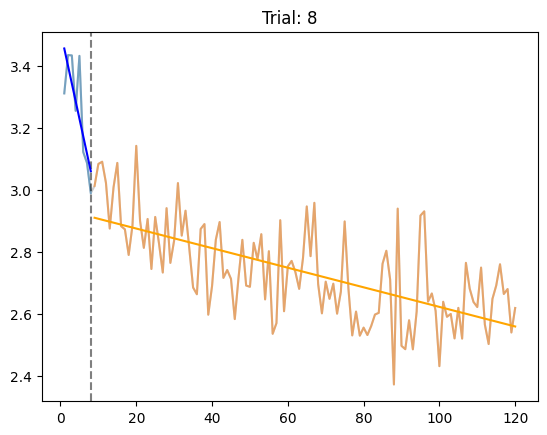

In [431]:
# Plotting candidate partitions - scarce
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_scarce:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [250]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Cut-off Point for Control Condition

In [367]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 0]

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_z_scores_control = []
control_plot_data = []
for trialNum in range(2,28,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_control.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos_control[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_control[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[6.]


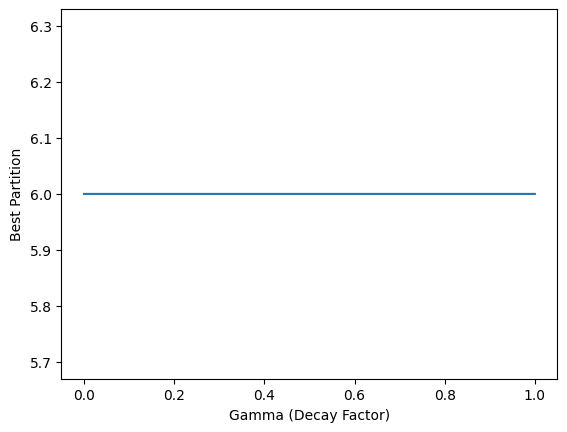

In [372]:
# Finding the best partition of all significant ones

sig_z_scores_control = np.array(sig_z_scores_control)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    #partition_scores = sig_z_scores_control[:,2] * (gamma ** sig_z_scores_control[:,0])
    
    # Sum of absolute correlation coeffs
    #partition_scores = sig_z_scores_control[:,4] + sig_z_scores_control[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_control[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_control[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


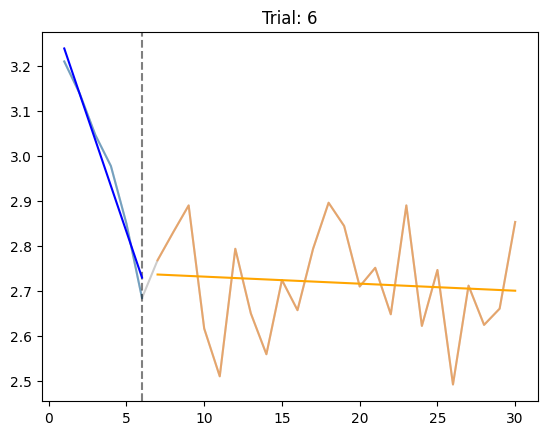

In [373]:
# Plotting candidate partitions - scarce
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_control:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [254]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

### Finding Cut-off Point for Both Conditions Together

In [390]:
# GLM 3 - finding cut off point of both phases together

test_df = analysis_data

mixed = False
    
# For all trials
relevant_trials = test_df

all_trials_mean = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos = list(range(1,len(all_trials_mean)+1))

sig_z_scores_all = []
all_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])

    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_all.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos[0:len(partition_1_df_mean)]
    x2 = all_trial_nos[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    all_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[14.]


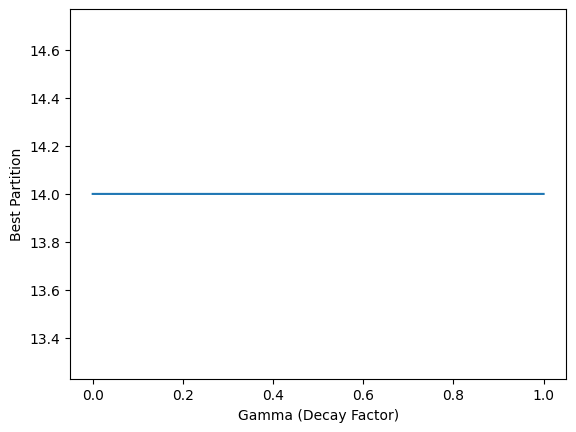

In [391]:
# Finding the best partition of all significant ones

sig_z_scores_all = np.array(sig_z_scores_all)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    #partition_scores = sig_z_scores_all[:,2] * (gamma ** sig_z_scores_all[:,0])
    
    # Sum of absolute correlation coeffs
    partition_scores = sig_z_scores_all[:,4] + sig_z_scores_all[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_all[:,2]
    
    # Absolute difference in slope
    #partition_scores = sig_z_scores_all[:,3]
    
    best_partition = sig_z_scores_all[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


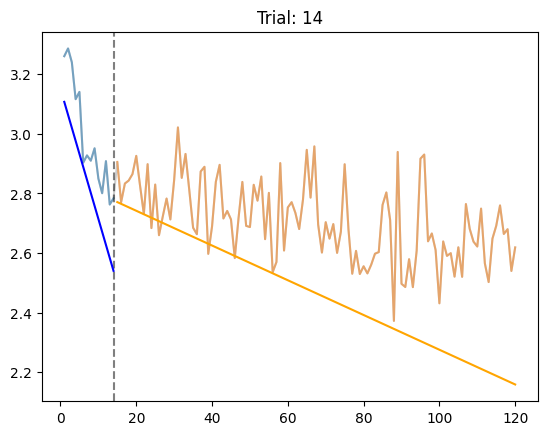

In [392]:
# Plotting candidate partitions - all
candidate_plot_data_all = [data for data in all_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_all:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos, all_trials_mean, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [223]:
all_partition = 7 # Somehow choose based on possible candidates

# Separating into learning and performance phase
all_learning_data = analysis_data.loc[(analysis_data.trialNumbers <= control_partition)]
all_performance_data = analysis_data.loc[(analysis_data.trialNumbers > control_partition)]

# Without transformation
all_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= scarce_partition)]
all_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
all_partition_plot_data = [data for data in candidate_plot_data_all if data[0] == all_partition][0]

In [224]:
# Re-partition individual condition learning/performance phases based on joint partition

# Separating into learning and performance phase
control_learning_data_joint = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= all_partition)]
control_performance_data_joint = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > all_partition)]

# Without transformation
control_learning_data_orig_joint = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= all_partition)]
control_performance_data_orig_joint = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > all_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data_joint = [data for data in control_plot_data if data[0] == all_partition][0]

In [225]:
# Re-partition individual condition learning/performance phases based on joint partition

# Separating into learning and performance phase
scarce_learning_data_joint = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= all_partition)]
scarce_performance_data_joint = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > all_partition)]

# Without transformation
scarce_learning_data_orig_joint = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= all_partition)]
scarce_performance_data_orig_joint = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > all_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data_joint = [data for data in scarce_plot_data if data[0] == all_partition][0]

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [41]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []
for trialNum in range(2,60,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_mean_scores = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0].groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1].groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept'] #+ results_1.params['C(isPerformanceTrial)[T.1]']
    i2 = results_1.params['Intercept'] #+ results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[5.]


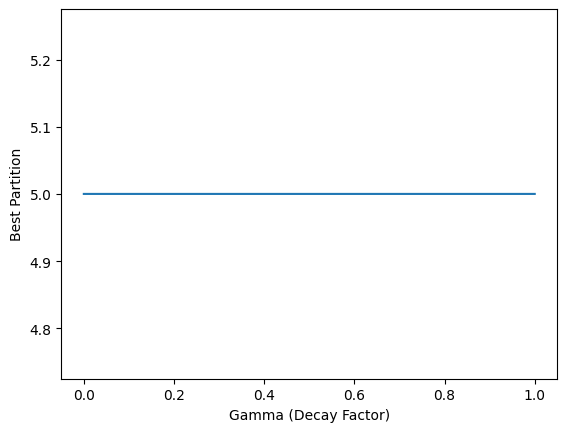

In [42]:
# Finding the best partition of all significant ones 

sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_scarce[:,1]
    best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [43]:
# Showing GLM results - scarce
candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_scarce:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 5

Two-Slope Model:
BIC LLF: 4504.8195

BIC Deviance: -16652.5460

AIC: 4487.6237

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 2280
Model:                            GLM   Df Residuals:                     2277
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                         0.41856
Method:                          IRLS   Log-Likelihood:                -2240.8
Date:                Tue, 27 Sep 2022   Deviance:                       953.06
Time:                        18:21:51   Pearson chi2:                     953.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06152
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_7818/3372657781.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


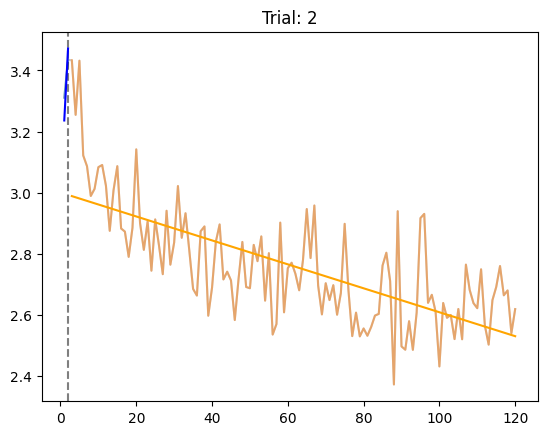

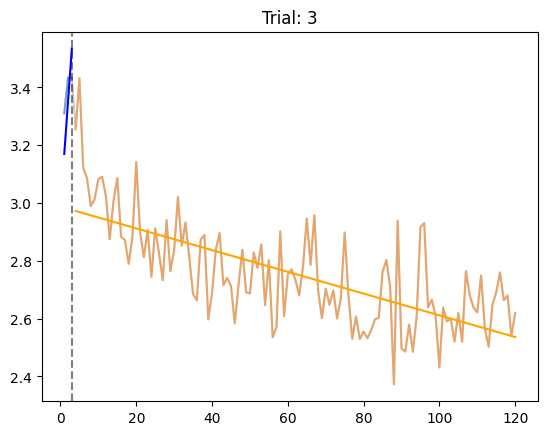

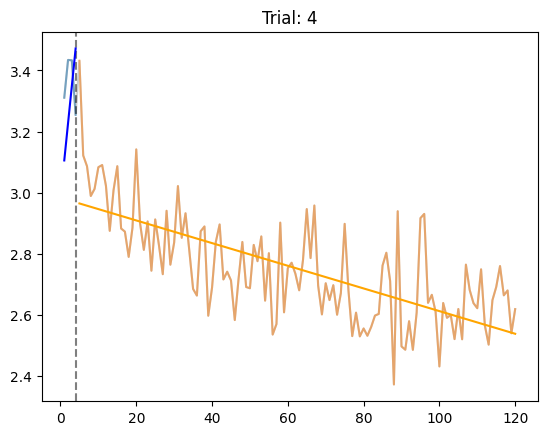

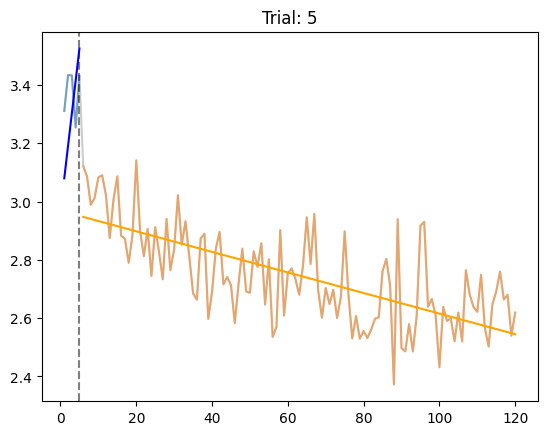

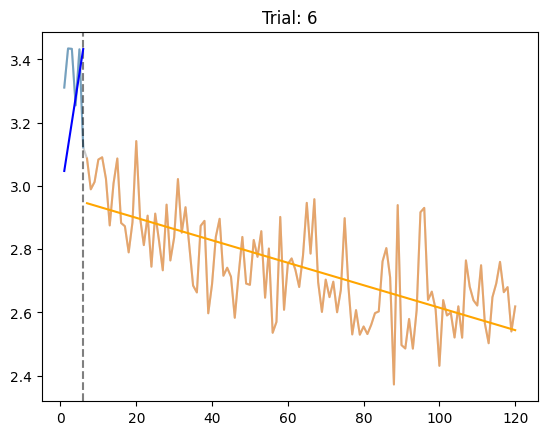

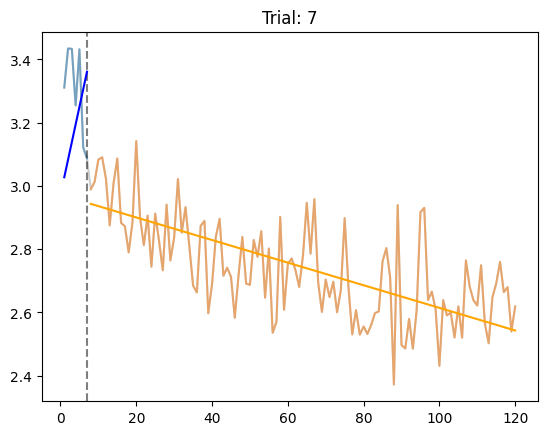

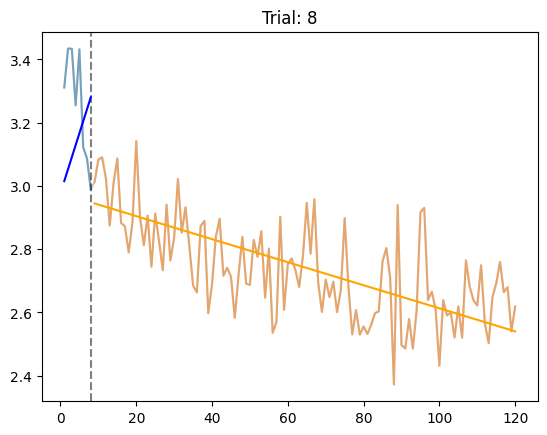

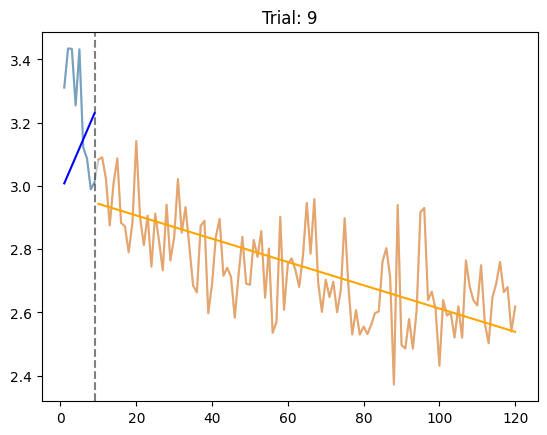

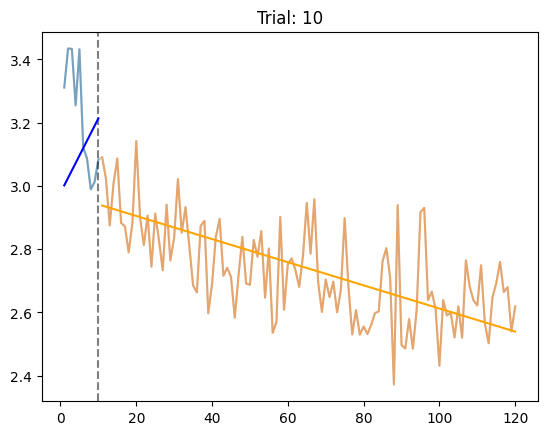

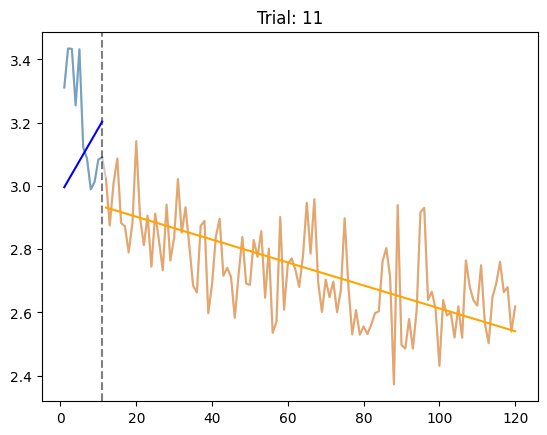

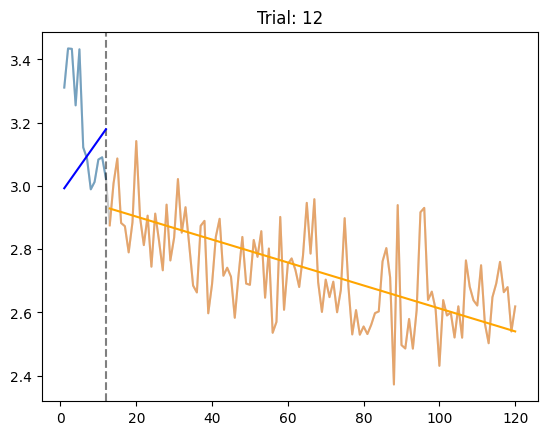

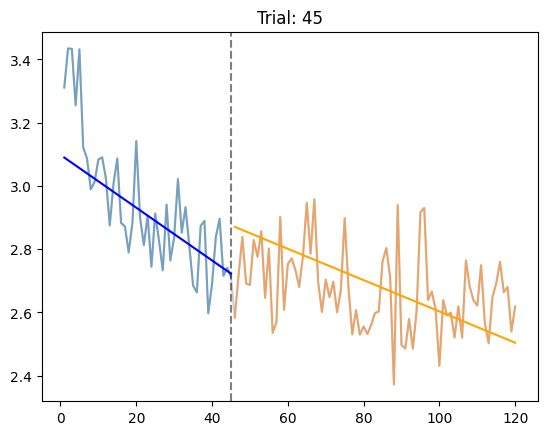

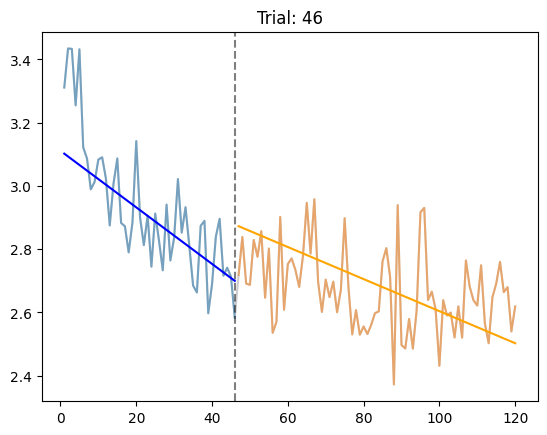

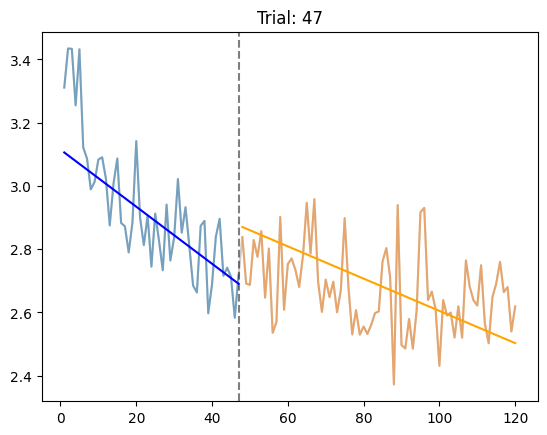

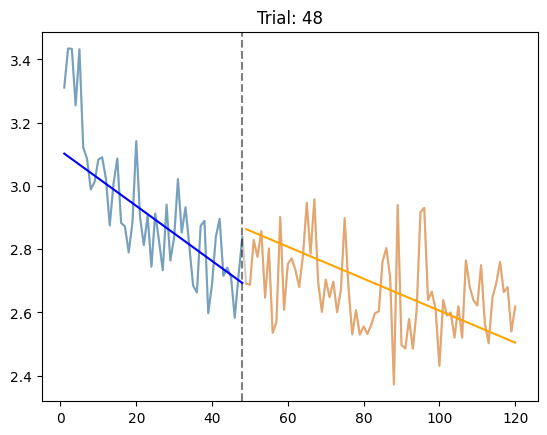

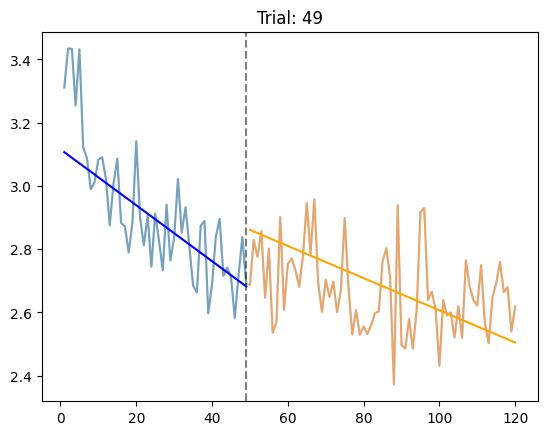

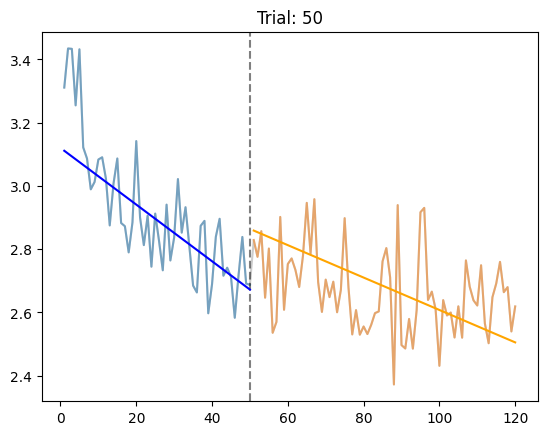

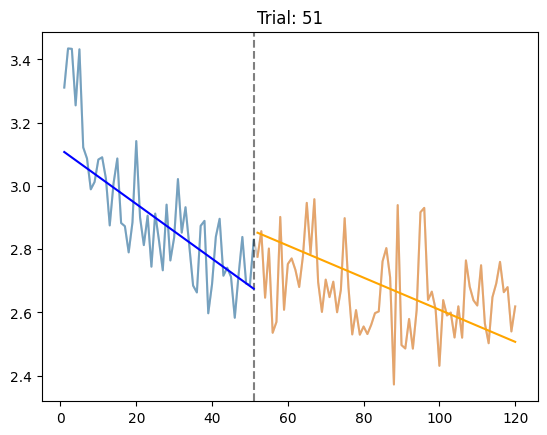

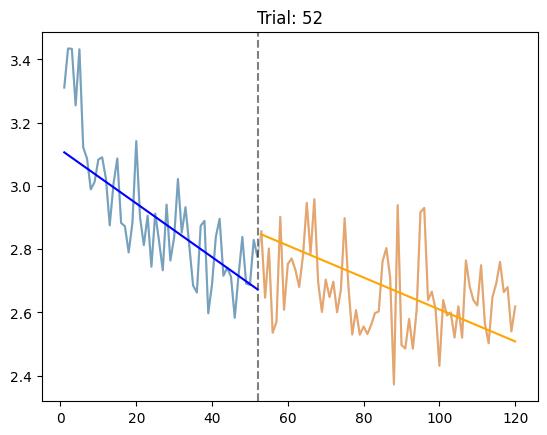

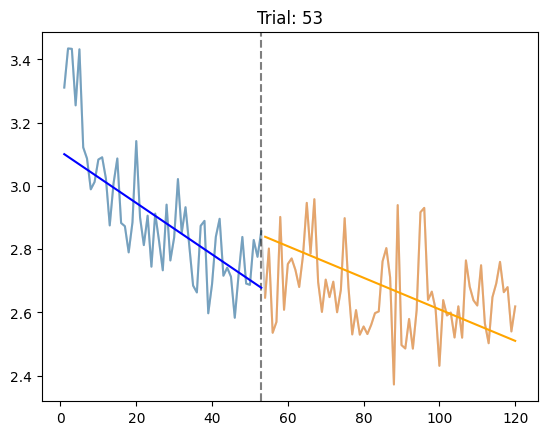

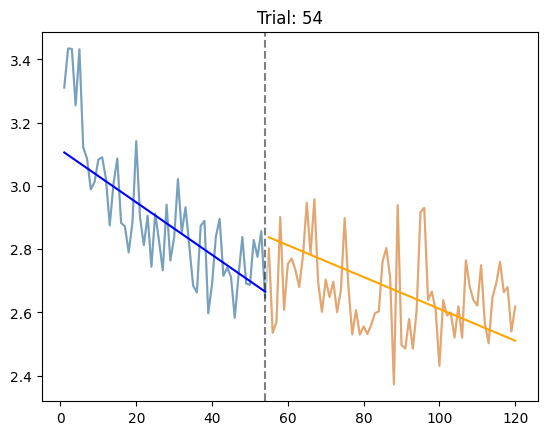

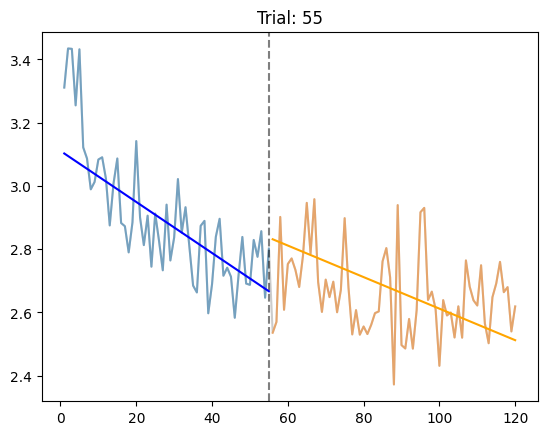

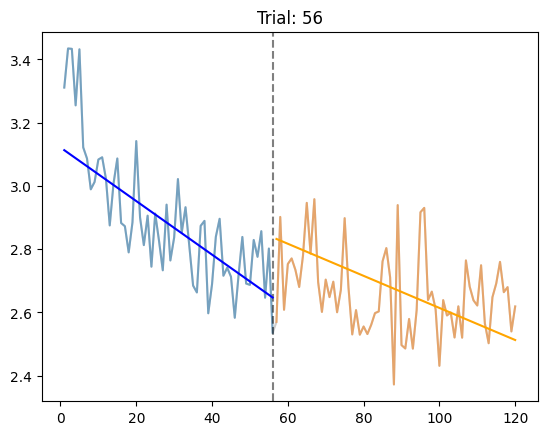

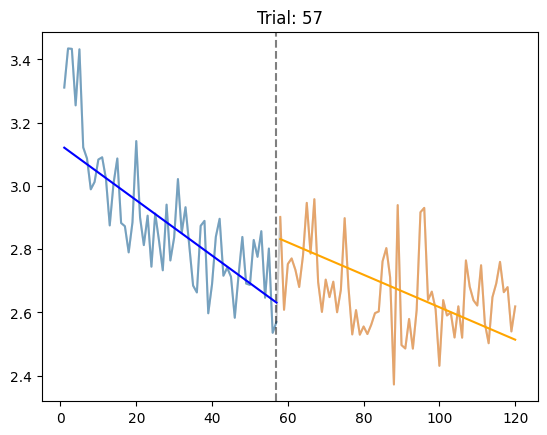

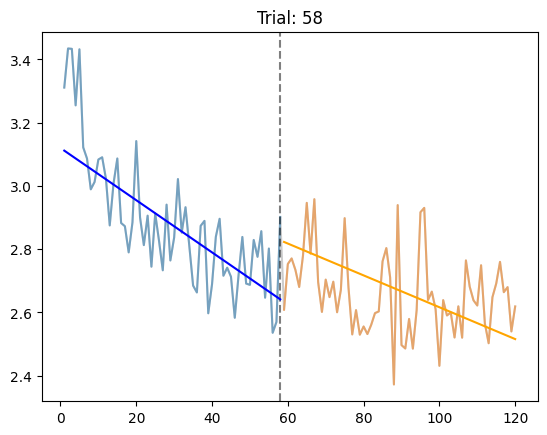

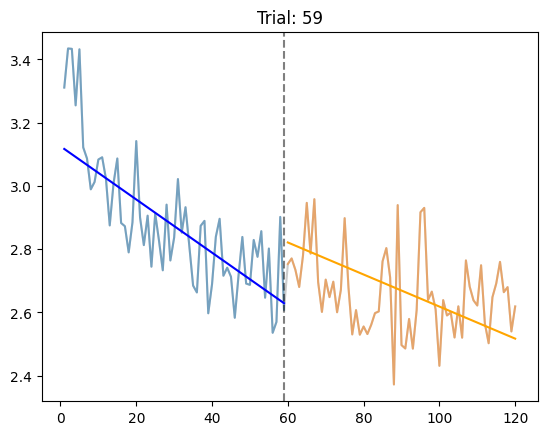

In [44]:
# Plotting candidate partitions - control
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

which_plot = "significant" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data
    
plot_single_slope = False
plot_two_slope = True

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [253]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [327]:
relevant_trials

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,isPerformanceTrial
0,38.0,3.714479,1,0,0,0,6140be2fdc5e6f433f412f7a,False,0
1,30.0,3.898487,2,0,1,0,6140be2fdc5e6f433f412f7a,False,0
2,30.0,3.278836,3,0,2,0,6140be2fdc5e6f433f412f7a,False,0
3,25.0,3.427062,4,0,3,0,6140be2fdc5e6f433f412f7a,False,0
4,52.0,3.941868,5,0,4,0,6140be2fdc5e6f433f412f7a,False,0
...,...,...,...,...,...,...,...,...,...
2845,40.0,2.933732,26,0,25,0,6130ceb2390f7cb3284f33a9,False,0
2846,31.0,3.247533,27,0,26,0,6130ceb2390f7cb3284f33a9,False,0
2847,26.0,3.398442,28,0,27,0,6130ceb2390f7cb3284f33a9,False,0
2848,58.0,1.935438,29,0,28,0,6130ceb2390f7cb3284f33a9,False,0


In [409]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.scarce == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,30,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_mean_scores = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0].groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1].groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + C(scarce) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers + C(scarce)"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
#     print(bic1, bic2)
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [317]:
sig_bic_scores_control

[(3, 961.3655539396835),
 (4, 958.5719796860226),
 (5, 957.8721170342452),
 (6, 957.990841031221),
 (7, 958.5815164014258),
 (8, 959.6610350896109),
 (9, 959.8236072036283),
 (10, 959.7109396834837),
 (11, 957.5647179515964),
 (12, 960.7073065558349),
 (13, 960.8422514930957),
 (14, 958.5529171198896),
 (15, 960.8739149309163),
 (16, 960.6969129343408)]

Partition candidates: 
[11.]


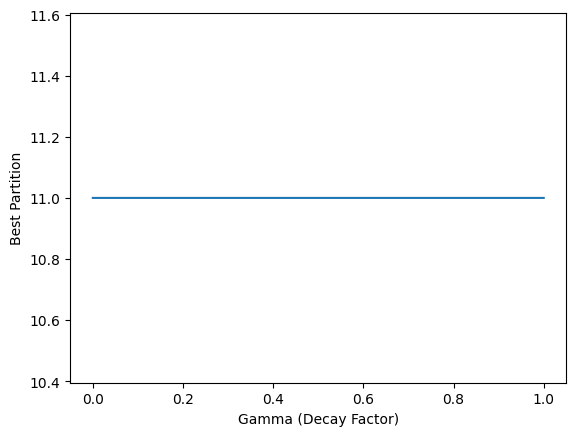

In [410]:
# Finding the best partition of all significant ones 

sig_bic_scores_control = np.array(sig_bic_scores_control)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_control[:,1]
    best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [319]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

significant_glm_data_control = [data for data in control_glm_results if float(data[0]) in sig_bic_scores_control[:,0]]

which_results = "all" #all, significant, candidates

if which_results == "candidates":
    result_data = candidate_glm_results_control
elif which_results == "significant":
    result_data = significant_glm_data_control
else:
    result_data = control_glm_results
    
filter_results = [6, 11]
for trialNum, results_1, results_2 in result_data:
    if len(filter_results) > 0 and trialNum not in filter_results: continue
    print("\nTrial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())



Trial Num: 6

Two-Slope Model:
BIC LLF: 957.9908

BIC Deviance: -3420.2449

AIC: 940.6083

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                  570
Model:                            GLM   Df Residuals:                      566
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.30280
Method:                          IRLS   Log-Likelihood:                -466.30
Date:                Mon, 26 Sep 2022   Deviance:                       171.39
Time:                        15:22:23   Pearson chi2:                     171.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05599
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----------

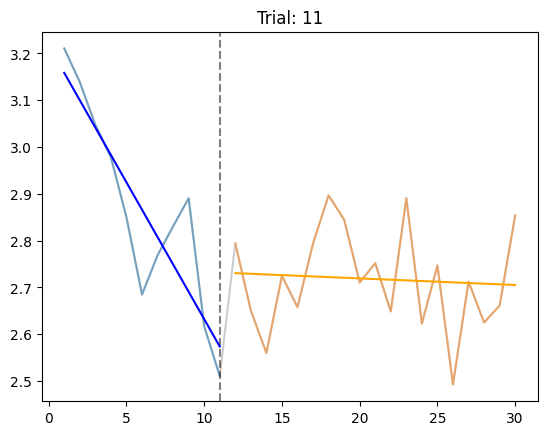

In [412]:
# Plotting candidate partitions - scarce
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [259]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce ==0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

# 1.1.2 - Linear Regression: Finding Cut-off Point for Learning Phase while enforcing Intercept

### Finding Cut-off Point for Scarce Condition

In [417]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1]

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_z_scores_scarce = []
scarce_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    
    formula = "expectedScores ~ trialNumbers"
    if mixed:
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_2 = smf.glm(formula=formula, data=partition_2_df)
    try:
        results_2 = glm_2.fit()
    except:
        continue
        
    b2 = results_2.params['trialNumbers']
    i2 = results_2.params['Intercept']
    se2 = results_2.bse['trialNumbers']
    
    intercept_shift = (b2 * trialNum + i2)
    # Shift the learning data based on this
    partition_1_shifted_df = partition_1_df.copy()
    # Reverse the trial numbers of the learning phase
    partition_1_shifted_df['trialNumbers'] = -partition_1_shifted_df['trialNumbers'] + trialNum
    partition_1_shifted_df['expectedScores'] = partition_1_shifted_df['expectedScores'] - intercept_shift
    partition_1_df_mean_shift = partition_1_shifted_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Comment these out later to plot the original data
#     partition_1_df = partition_1_shifted_df
#     partition_1_df_mean = partition_1_df_mean_shift
    
    # Regress for learning phase on shifted data with constrained intercept
    no_int_formula = formula + " -1"
    if mixed:
        glm_1 = smf.mixedlm(formula=no_int_formula, data=partition_1_shifted_df, groups=partition_1_shifted_df['workerId'])
    else:
        glm_1 = smf.glm(formula=no_int_formula, data=partition_1_shifted_df)
    try:
        results_1 = glm_1.fit()
    except:
        continue
    
    # Invert the slope 
    b1 = -results_1.params['trialNumbers']
    
    # intercept relevant only for plotting
    i1 = -b1 * trialNum + intercept_shift
    se1 = results_1.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_scarce.append((trialNum, pvalue, z, bdiff))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_scarce[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[3.]


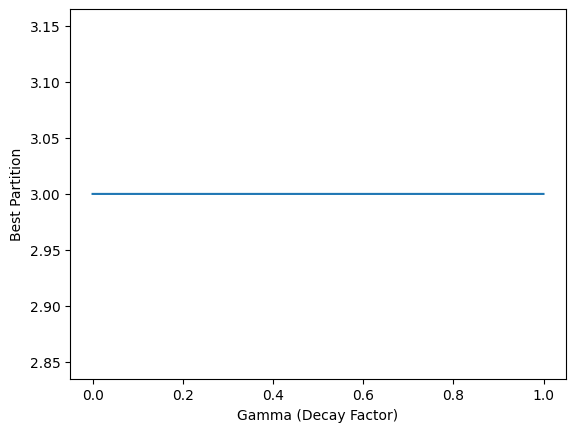

In [420]:
# Finding the best partition of all significant ones 

sig_z_scores_scarce = np.array(sig_z_scores_scarce)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_scarce[:,2] * (gamma ** sig_z_scores_scarce[:,0])
    
    # Absolute z-score
    # partition_scores = sig_z_scores_scarce[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_scarce[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


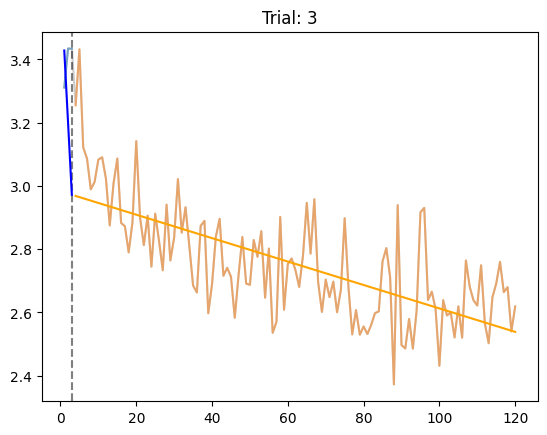

In [421]:
# Plotting candidate partitions - control
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_z_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Slope lines of two-slope model
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [138]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Cut-off Point for Control Condition

In [424]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 0]

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_z_scores_control = []
control_plot_data = []
for trialNum in range(2,15,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    
    formula = "expectedScores ~ trialNumbers"
    if mixed:
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_2 = smf.glm(formula=formula, data=partition_2_df)
    try:
        results_2 = glm_2.fit()
    except:
        continue
        
    b2 = results_2.params['trialNumbers']
    i2 = results_2.params['Intercept']
    se2 = results_2.bse['trialNumbers']
    
    intercept_shift = (b2 * trialNum + i2)
    # Shift the learning data based on this
    partition_1_shifted_df = partition_1_df.copy()
    # Reverse the trial numbers of the learning phase
    partition_1_shifted_df['trialNumbers'] = -partition_1_shifted_df['trialNumbers'] + trialNum
    partition_1_shifted_df['expectedScores'] = partition_1_shifted_df['expectedScores'] - intercept_shift
    partition_1_df_mean_shift = partition_1_shifted_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Comment these out later to plot the original data
#     partition_1_df = partition_1_shifted_df
#     partition_1_df_mean = partition_1_df_mean_shift
    
    # Regress for learning phase on shifted data with constrained intercept
    no_int_formula = formula + " -1"
    if mixed:
        glm_1 = smf.mixedlm(formula=no_int_formula, data=partition_1_shifted_df, groups=partition_1_shifted_df['workerId'])
    else:
        glm_1 = smf.glm(formula=no_int_formula, data=partition_1_shifted_df)
    try:
        results_1 = glm_1.fit()
    except:
        continue
    
    # Invert the slope 
    b1 = -results_1.params['trialNumbers']
    
    # intercept relevant only for plotting
    i1 = -b1 * trialNum + intercept_shift
    se1 = results_1.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_control.append((trialNum, pvalue, z, bdiff))
        
    x1 = all_trial_nos_control[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_control[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[2.]


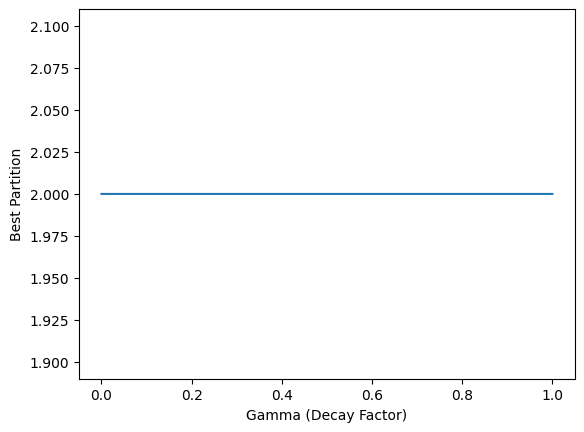

In [427]:
# Finding the best partition of all significant ones 

sig_z_scores_control = np.array(sig_z_scores_control)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_control[:,2] * (gamma ** sig_z_scores_control[:,0])
    
    # Absolute z-score
    partition_scores = sig_z_scores_control[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_control[:,3]
    best_partition = sig_z_scores_control[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


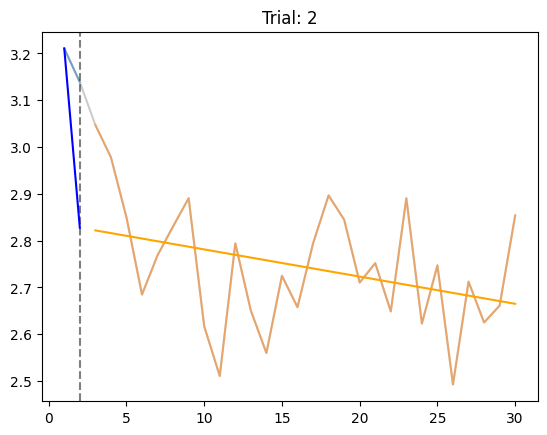

In [428]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_z_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Slope lines of two-slope model
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [237]:
scarce_partition = 18 # partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

IndexError: list index out of range

# 1.2 - Linear Regression: Expected Score vs. Trial Number x Condition

In [261]:
# True if using cut-off points found on both condition data
joint_partition = False

if joint_partition:
    control_plot = control_partition_plot_data_joint
    scarce_plot = scarce_partition_plot_data_joint
else:
    control_plot = control_partition_plot_data
    scarce_plot = scarce_partition_plot_data

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     551        Method:                REML          
No. Groups:           38         Scale:                 0.3253        
Min. group size:      11         Log-Likelihood:        -518.6123     
Max. group size:      18         Converged:             Yes           
Mean group size:      14.5                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.217    0.121 26.533 0.000  2.979  3.455
C(scarce)[T.1]               0.194    0.162  1.194 0.233 -0.124  0.512
trialNumbers                -0.058    0.012 -4.685 0.000 -0.083 -0.034
trialNumbers:C(scarce)[T.1]  0.026    0.014  1.857 0.063 -0.001  0.053
Group Var              

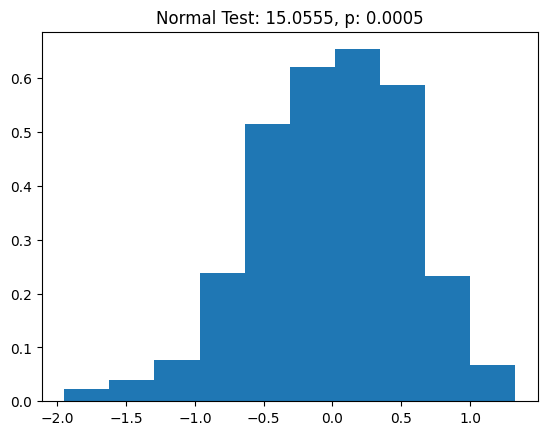

In [265]:
# Learning Phase

if joint_partition:
    learning_df = all_learning_data
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)
#learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
#learning_df = control_learning_data

formula = 'expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

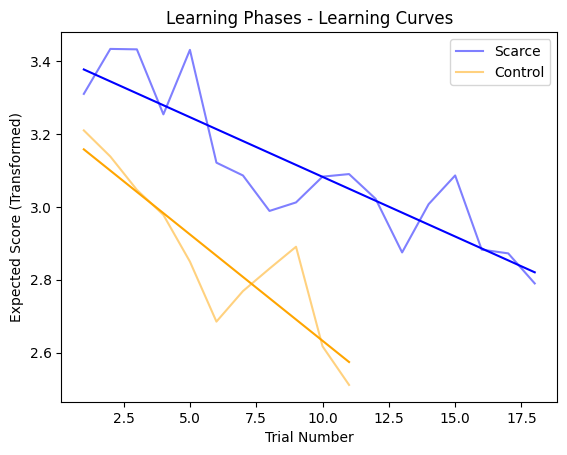

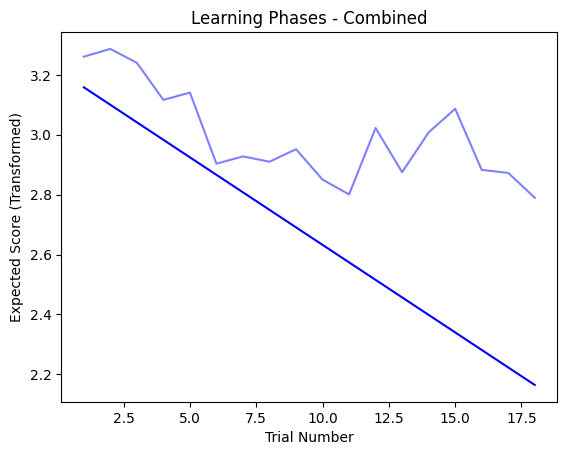

In [263]:
# Plotting the data of both learning phases

x1 = control_plot[1]
x2 = scarce_plot[1]
y1 = control_plot[3]
y2 = scarce_plot[3]
b1 = control_plot[5]
b2 = scarce_plot[5]
i1 = control_plot[7]
i2 = scarce_plot[7]

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.legend()

# Plotting the output of the GLM on the combined data
plt.figure()
y = learning_df.groupby("trialNumbers").mean()["expectedScores"]
y_err = np.abs(learning_df.groupby("trialNumbers").std()["expectedScores"])
x = y.index
b = results.params['trialNumbers']
i = results.params['Intercept']

plt.plot(x,y,alpha = 0.5, color='b')
# plt.fill_between(x, y + y_err, y - y_err, alpha=0.1)
plt.plot(x, np.array(x) * b + i, color='b')
plt.title("Learning Phases - Combined")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.show()



                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2299       Method:                REML          
No. Groups:           38         Scale:                 0.2836        
Min. group size:      19         Log-Likelihood:        -1873.7922    
Max. group size:      102        Converged:             Yes           
Mean group size:      60.5                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    2.748    0.126 21.734 0.000  2.500  2.995
C(scarce)[T.1]               0.148    0.143  1.030 0.303 -0.133  0.429
trialNumbers                -0.001    0.005 -0.275 0.783 -0.011  0.009
trialNumbers:C(scarce)[T.1] -0.001    0.005 -0.242 0.809 -0.011  0.009
Group Var              

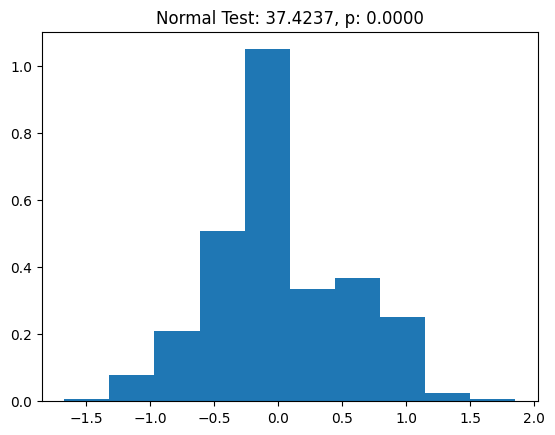

In [266]:
# Performance Phase

if joint_partition:
    performance_df = all_performance_data
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# performance_df = scarce_performance_data

formula = 'expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

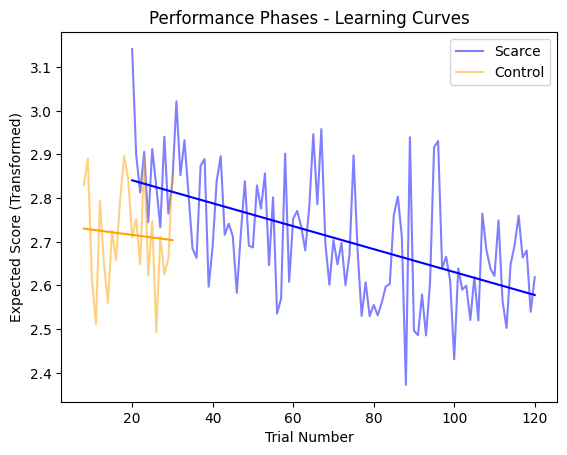

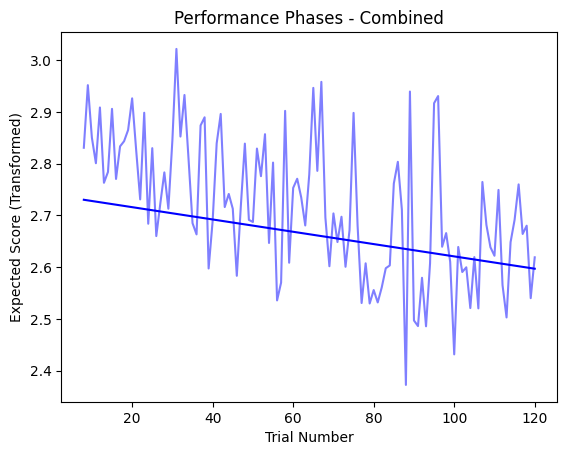

In [235]:
# Plotting the data of both performance phases together

x1 = control_plot[2]
x2 = scarce_plot[2]
y1 = control_plot[4]
y2 = scarce_plot[4]
b1 = control_plot[6]
b2 = scarce_plot[6]
i1 = control_plot[8]
i2 = scarce_plot[8]

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.legend()

# Plotting the output of the GLM on the combined data
plt.figure()
y = performance_df.groupby("trialNumbers").mean()["expectedScores"]
x = y.index
b = results.params['trialNumbers']
i = results.params['Intercept']

plt.plot(x,y,alpha = 0.5, color='b')
plt.plot(x, np.array(x) * b + i, color='b')
plt.title("Performance Phases - Combined")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.show()


# 1.3 - Linear Regression: Expected Score vs. Num Rewarded Trials

In [327]:
test = learning_df[['numRewardedTrials','numUnrewardedTrials','scarce']]
test['un:scarce'] = test["numUnrewardedTrials"] * test["scarce"]
test['re:scarce'] = test["numRewardedTrials"] * test["scarce"]
test.loc[(test.scarce==1) & (test.numUnrewardedTrials > 0)]
test.corr()

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_15607/1224191848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['un:scarce'] = test["numUnrewardedTrials"] * test["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_15607/1224191848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['re:scarce'] = test["numRewardedTrials"] * test["scarce"]


,numRewardedTrials,numUnrewardedTrials,scarce,un:scarce,re:scarce
numRewardedTrials,1.000000,-0.152373,-0.502951,-0.152373,0.078567
numUnrewardedTrials,-0.152373,1.000000,0.695217,1.000000,0.743968
scarce,-0.502951,0.695217,1.000000,0.695217,0.614534
un:scarce,-0.152373,1.000000,0.695217,1.000000,0.743968
re:scarce,0.078567,0.743968,0.614534,0.743968,1.000000


In [332]:
test.loc[test.scarce==1][0:20]

,numRewardedTrials,numUnrewardedTrials,scarce,un:scarce,re:scarce
30,0,0,1,0,0
31,0,1,1,1,0
32,0,2,1,2,0
33,0,3,1,3,0
34,1,3,1,3,1
35,1,4,1,4,1
36,1,5,1,5,1
37,1,6,1,6,1
38,1,7,1,7,1
39,2,7,1,7,2


In [335]:
# GLM 2 - Expected score vs num rewarded trials 

learning_df = pd.concat([scarce_learning_data, control_learning_data])

formula = 'expectedScores ~ numUnrewardedTrials:C(scarce)' # + numRewardedTrials:C(scarce)' # + numUnrewardedTrials:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

LinAlgError: Singular matrix

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores
No. Observations: 568     Method:             REML          
No. Groups:       19      Scale:              0.2966        
Min. group size:  29      Log-Likelihood:     -475.0962     
Max. group size:  30      Converged:          Yes           
Mean group size:  29.9                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.917    0.052 56.614 0.000  2.816  3.018
numRewardedTrials -0.010    0.003 -3.864 0.000 -0.015 -0.005
Group Var          0.013    0.014                           



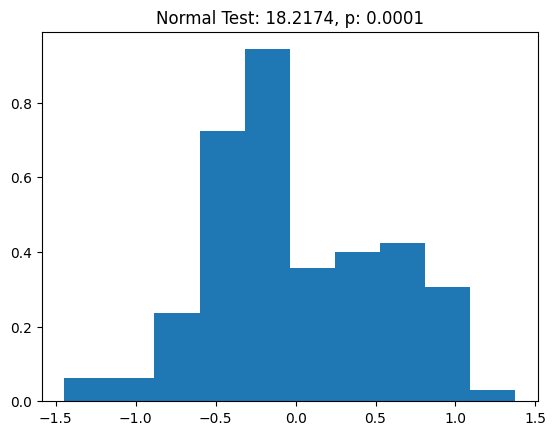

In [193]:
# GLM 2 - Expected score vs num rewarded trials (within group)

test_df = cb2_transformed_trials_df

non_scarce_df = test_df.loc[test_df.scarce == 0]

formula = 'expectedScores ~ numRewardedTrials'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=non_scarce_df, groups=non_scarce_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=non_scarce_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

# 1.4 - Independent Samples T-test

In [70]:
use_transformed = True

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean()
    scarce_averages = scarce_performance_data.groupby('workerId').mean()
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean()
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean()
    

/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


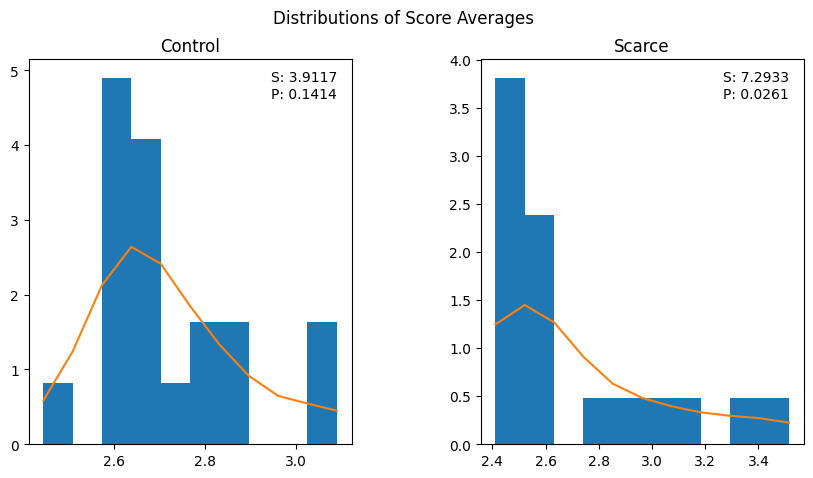

In [71]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Score Averages")
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Scarce")]):
    data = group[0]["expectedScores"]
    label = group[1]
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [72]:
# Perform independent T-test if data is normal

scipy.stats.ttest_ind(scarce_averages.expectedScores, control_averages.expectedScores, equal_var=True)

Ttest_indResult(statistic=-0.08867041326759303, pvalue=0.9298352971969951)

In [73]:
# Perform Mann-Whitney U test if data is not normal

scipy.stats.mannwhitneyu(scarce_averages.expectedScores, control_averages.expectedScores)

MannwhitneyuResult(statistic=124.0, pvalue=0.10206878773216894)